In [5]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, latent_size, multiplier=4, img_size=64):
        super(AE, self).__init__()
        out_channels = 1
        self.fm = img_size // 16
        self.mp = multiplier
        self.encoder = nn.Sequential(
            nn.Conv2d(1, int(16 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(16 * multiplier),
                      int(32 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(32 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(64 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
        )
        self.linear_enc = nn.Sequential(
            nn.Linear(int(64 * multiplier) * self.fm*self.fm, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, latent_size),
        )
        

        self.linear_dec = nn.Sequential(
            nn.Linear(latent_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, int(64 * multiplier) * self.fm*self.fm),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(int(64*multiplier), int(64 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(64*multiplier), int(32 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(32*multiplier), int(16 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(16*multiplier),
                               out_channels, 4, 2, 1, bias=False),
        )

    def forward(self, x):
        lat_rep = self.feature(x)
        out = self.decode(lat_rep)
        return out

    def feature(self, x):
        lat_rep = self.encoder(x)
        lat_rep = lat_rep.view(lat_rep.size(0), -1)
        lat_rep = self.linear_enc(lat_rep)
        return lat_rep

    def decode(self, x):
        out = self.linear_dec(x)
        out = out.view(out.size(0), int(64 * self.mp), self.fm, self.fm)
        out = self.decoder(out)
        return out


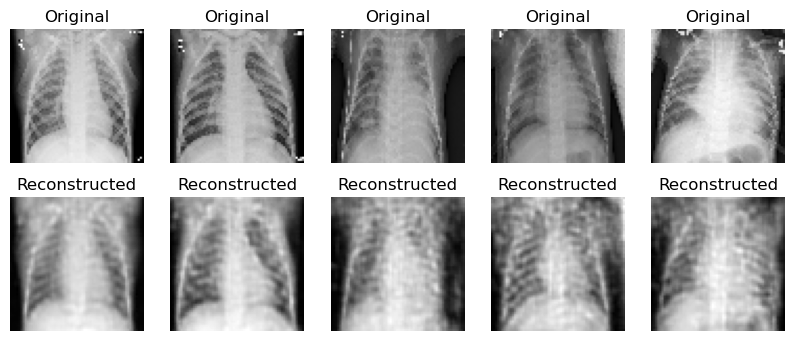

Error rate:0.5299145299145299
Precision:0.5960912052117264 Sensitivity:0.46923076923076923 Specificity:0.4700854700854701 f1:0.5251076040172167



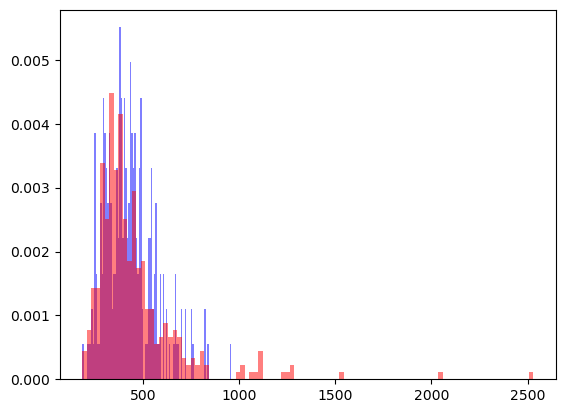

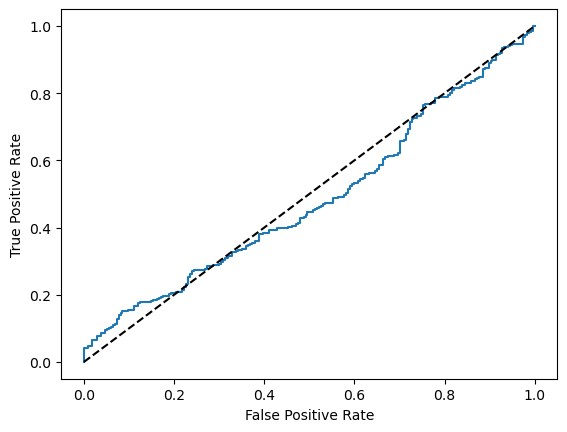

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.metrics import accuracy_score

BATCH_SIZE = 64
IMG_SIZE = 64

# Load preprocessed data
X_train = np.load('X_train_gray_noraml.npy')
y_train = np.load('y_train_gray_normal.npy')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Load preprocessed data
X_test = np.load('X_test_gray.npy')
y_test = np.load('y_test_gray.npy')

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Define dataset and dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


def train_loop(model, loader, test_loader):
    optim = torch.optim.Adam(model.parameters(), 5e-4, betas=(0.5, 0.999))
    for e in tqdm(range(EPOCHS)):
        model.train()
        loass_array = []
        for (x, _) in loader:
            x.requires_grad = False
            x.permute(0, 3, 1, 2)
            out = model(x)
            rec_err = (out - x) ** 2
            loss = rec_err.mean()
            loass_array.append(loss.item())
            optim.zero_grad()
            loss.backward()
            optim.step()
        loass_array = np.mean(loass_array)
        print('epochs:{}, loss:{}'.format(e, loass_array))
    torch.save(model.state_dict(), './models/AE_gray.pth')
    test_for_xray( model, test_loader)

def plotImages(out, x):
    out_np = out.detach().numpy()
    x_np = x.detach().numpy()

    # Plot original images
    plt.figure(figsize=(10, 4))
    for i in range(5):  # Plotting first 5 images as an example
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_np[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Plot reconstructed images
    for i in range(5):  # Plotting first 5 images as an example
        plt.subplot(2, 5, i + 6)
        plt.imshow(out_np[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

def metrics_at_eer(y_score, y_true):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    idx = None
    for i in range(len(fpr)):
        fnr = 1 - tpr[i]
        if abs(fpr[i] - fnr) <= 5e-3:
            idx = i
            break
    assert idx is not None

    t = thresholds[idx]
    y_pred = np.zeros_like(y_true)
    y_pred[y_score < t] = 0
    y_pred[y_score >= t] = 1
    pres = metrics.precision_score(y_true, y_pred)
    sens = metrics.recall_score(y_true, y_pred, pos_label=1)
    spec = metrics.recall_score(y_true, y_pred, pos_label=0)
    f1 = metrics.f1_score(y_true, y_pred)
    print('Error rate:{}'.format(fpr[idx]))
    print('Precision:{} Sensitivity:{} Specificity:{} f1:{}\n'.format(
        pres, sens, spec, f1))
    
def test_for_xray(model=None, loader=None):
    model.eval()
    flag = True
    with torch.no_grad():
        y_score, y_true = [], []
        for (x, label) in loader:
            x.permute(0, 3, 1, 2)
            out = model(x)
            if flag:
                flag = False
                plotImages(out, x)
            rec_err = (out - x) ** 2
            res = rec_err
            res = res.mean(dim=(1,2,3))
            y_true.append(label)
            y_score.append(res.view(-1))

        y_true = np.concatenate(y_true)
        y_score = np.concatenate(y_score)
        metrics_at_eer(y_score, y_true)
        plt.figure()        
        plt.hist(y_score[y_true == 0], bins=100,
                    density=True, color='blue', alpha=0.5)
        plt.hist(y_score[y_true == 1], bins=100,
                    density=True, color='red', alpha=0.5)
        plt.figure()
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

if __name__ == '__main__':
    EPOCHS = 10
    model = AE(latent_size=64)
    # train_loop(model, train_loader, test_loader)
    model_path = "./models/AE_gray.pth"
    model.load_state_dict(torch.load(model_path))
    test_for_xray(model, test_loader)